In [1]:
from __future__ import print_function
from fenics import *
import os
from mshr import *
import numpy as np
import matplotlib.pyplot as plt
from dolfin import *
import numpy as np
import time
from math import *
import sympy as sym

from numpy.random import rand

from operator import mul
from functools import reduce

from scipy.integrate import odeint

from reaction_diffusion_symbolic_defs import *

from reaction_diffusion_source_functions import *

%matplotlib inline
sym.init_printing()

# Reaction systems

In [2]:
reactions = [
    # (coeff, kinetic type, lhsStoich, netStoich)
    ('k1', 2,'Mass_Action', {}, {'U': 1}),
    ('k2', 10, 'Mass_Action', {'U': 1}, {'U': -1}),
    ('k3', 10, 'Mass_Action', {'U': 2,'V': 1}, {'U': 1, 'V': -1}),
    ('k4', 13, 'Mass_Action', {}, {'V': 1})
]

variable_names = ["U","V"]
diffusionValues = [100,2.5]
var_init_conds = [0.8,1.2]


# boundary conditions
boundary_conditions = {0: {'Neumann':[0,0]},
                       1: {'Neumann':[0,0]},
                       2: {'Neumann':[0,0]},
                       3: {'Neumann':[0,0]}}

# simulation metadata
file_root = 'RD_modelling/chaste_test/'
simulation_tag='10'
simulationType = 'Reaction'
domainType="homogenous"
#simulation settings
# simulation parameters
t_end = 1
t_initial = 0
n_time_step = 2
dt = 0.01#t_end / n_time_step

# mesh properties
nx = ny = 10

dt=  0.02


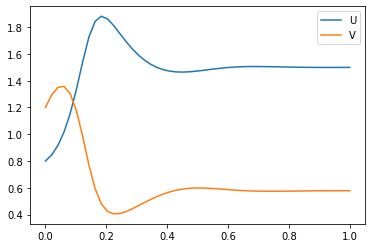

In [3]:
Reaction_ode_solver(reactions,[t_initial,t_end],var_init_conds)

HERe
Form has no parts with arity 2.


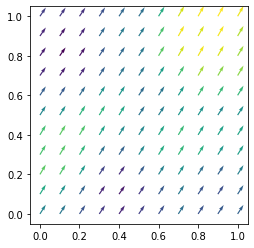

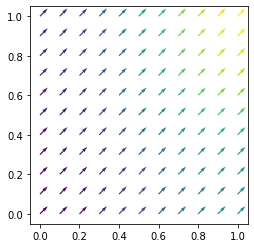

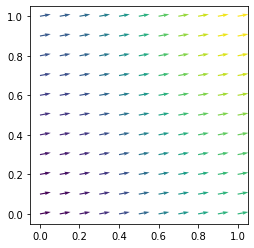

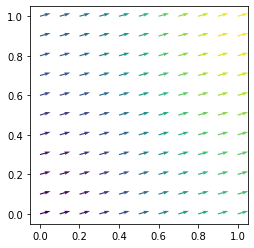

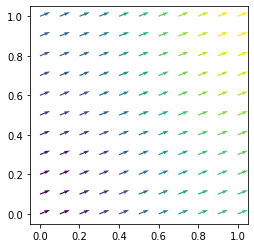

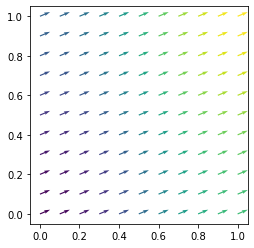

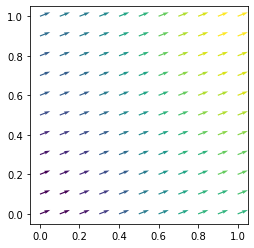

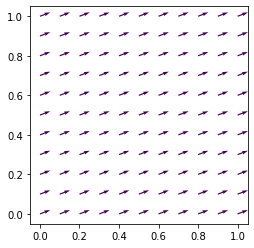

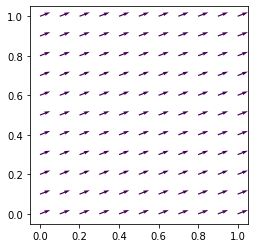

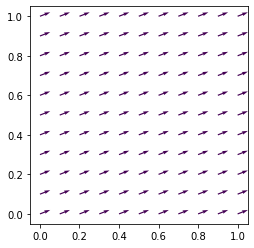

'RD_modelling/chaste_test/Reaction/10'

In [4]:
Reaction_pde_solver(reactions,variable_names,diffusionValues,var_init_conds,boundary_conditions,file_root,simulation_tag,simulationType,domainType,[t_initial,t_end,dt],[nx,ny])

# General systems

In [5]:
# Define the Ode term
variable_names = ['U','V']
source_term = ["U**2*V*k3 - U*k2 + k1","-U**2*V*k3 + k4"]
parameterList = [('k1',2),('k2',10),('k3',10),('k4',13)]

# define the spatial properties
diffusionValues = [100,2.5]
var_init_conds = [0.8,1.2]
# boundary conditions
boundary_conditions = {0: {'Neumann':[0,0]},
                       1: {'Neumann':[0,0]},
                       2: {'Neumann':[0,0]},
                       3: {'Neumann':[0,0]}}

# simulation metadata
file_root = 'RD_modelling/chaste_test/'
simulation_tag='1'
simulationType = 'General'
domainType="homogenous"

#simulation settings
# simulation parameters
t_end = 2
t_initial = 0
n_time_step = 2
dt = 0.01#t_end / n_time_step

# mesh properties
nx = ny = 10



Equlibria points:  []
dt=  0.04


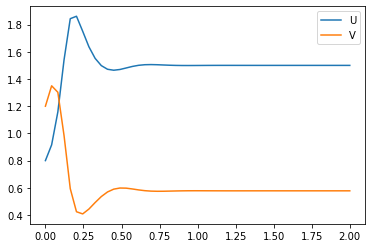

In [6]:
General_ode_solver(source_term,variable_names,parameterList,[t_initial,t_end],var_init_conds)

Form has no parts with arity 2.


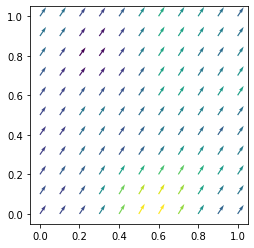

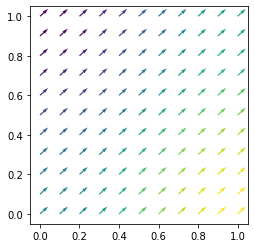

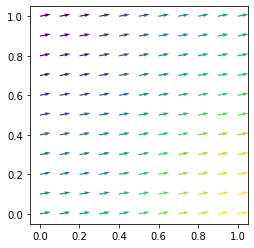

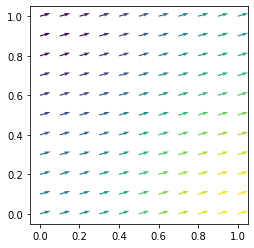

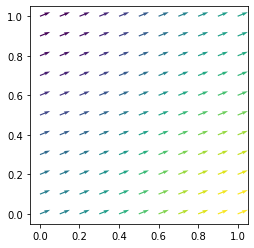

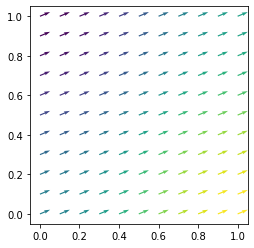

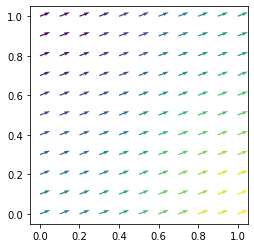

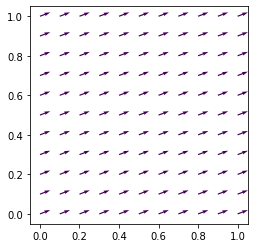

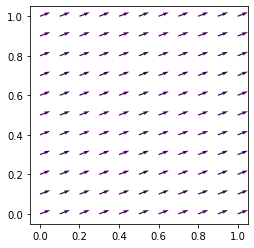

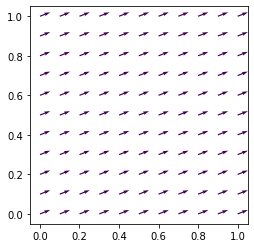

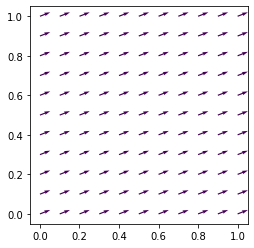

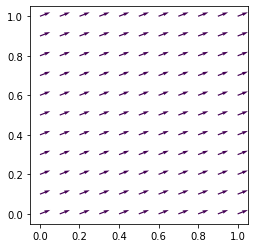

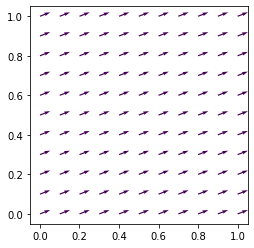

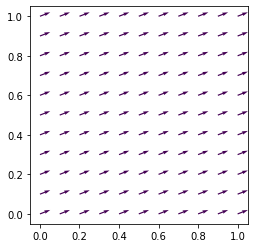

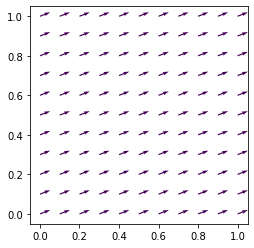

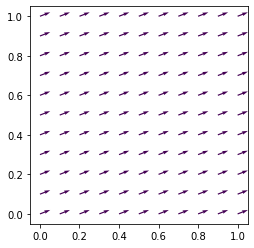

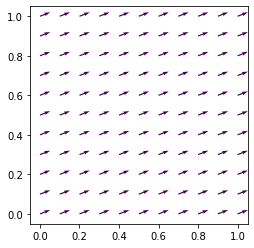

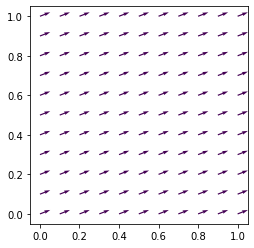

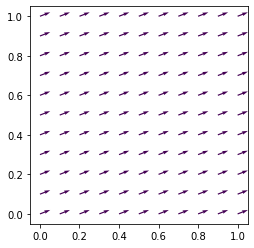

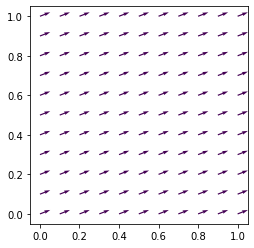

'RD_modelling/chaste_test/General/1'

In [7]:
General_pde_solver(source_term,parameterList,variable_names,diffusionValues,var_init_conds,boundary_conditions,file_root,simulation_tag,simulationType,domainType,[t_initial,t_end,dt],[nx,ny])

## Heat diffusion

In [8]:
# Define the Ode term
variable_names = ['U','V']
source_term = ["k1","k2"]
parameterList = [('k1',0),('k2',0)]

var_init_conds = [1,1]

# define the spatial properties
diffusionValues = [1,1]
# boundary conditions
boundary_conditions = {0: {'Neumann':[0]},
                       1: {'Neumann':[0]},
                       2: {'Neumann':[0]},
                       3: {'Neumann':[0]}}

# simulation metadata
file_root = 'RD_modelling/chaste_test/'
simulation_tag='4'
simulationType = 'General'
domainType="centre_peak"

#simulation settings
# simulation parameters
t_end = 10
t_initial = 0
n_time_step = 2
dt = 0.01#t_end / n_time_step

# mesh properties
nx = 100
ny =10

Equlibria points:  []
dt=  0.2


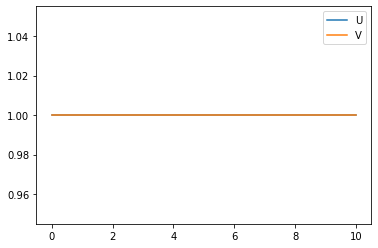

In [9]:
General_ode_solver(source_term,variable_names,parameterList,[t_initial,t_end],var_init_conds)

Form has no parts with arity 2.


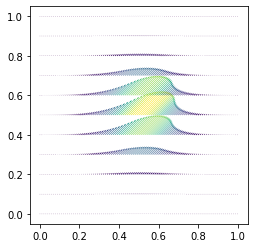

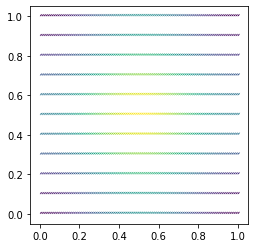

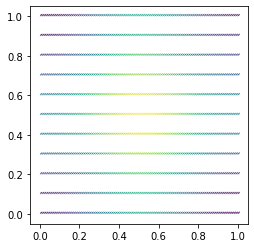

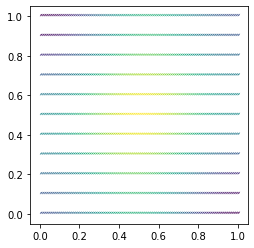

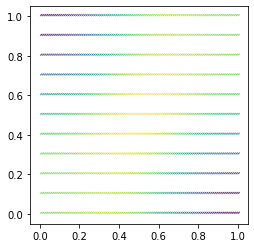

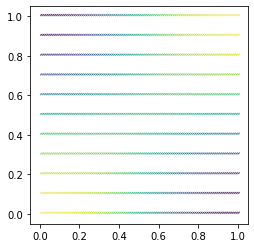

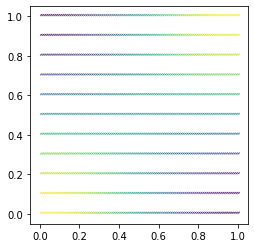

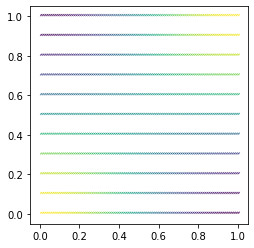

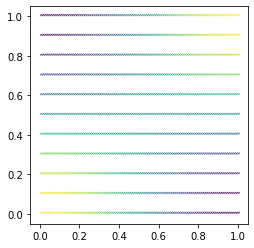

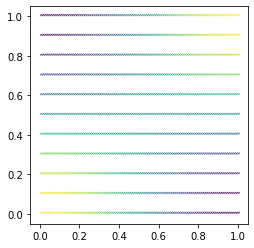

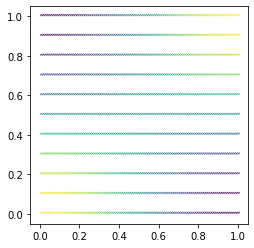

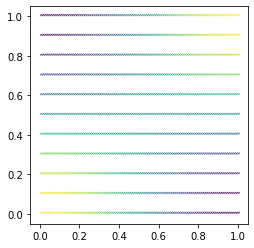

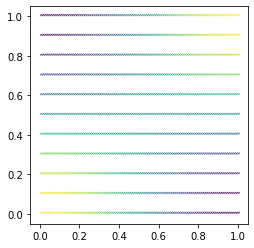

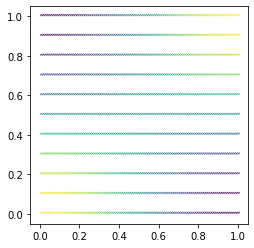

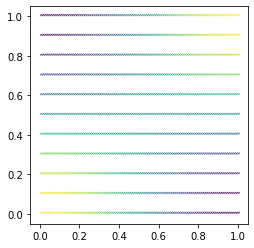

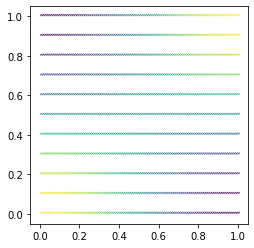

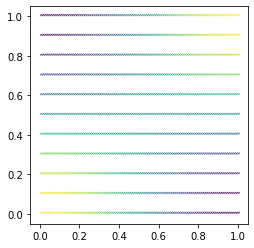

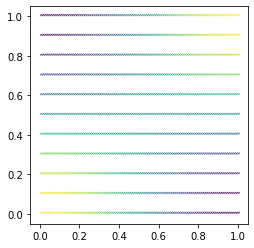

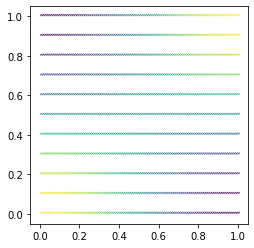

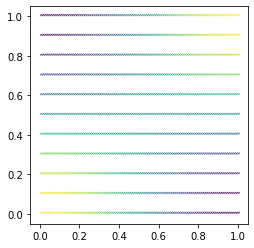

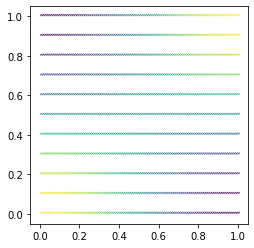

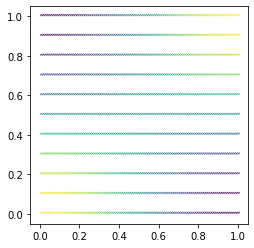

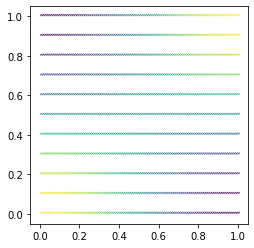

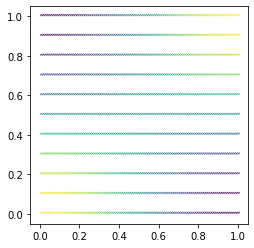

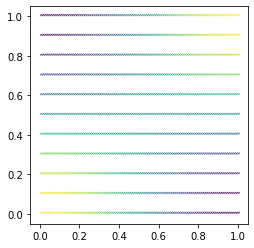

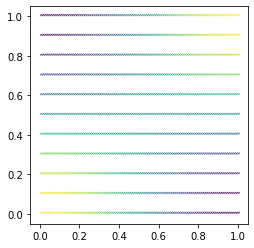

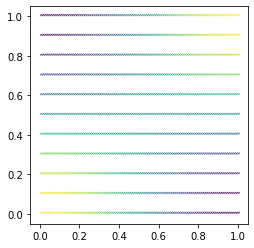

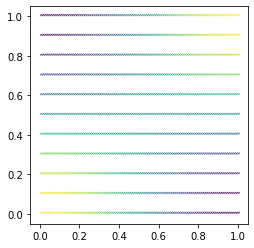

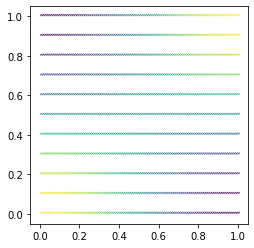

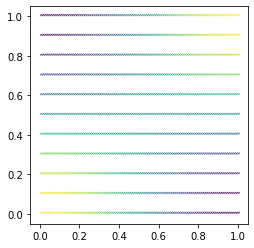

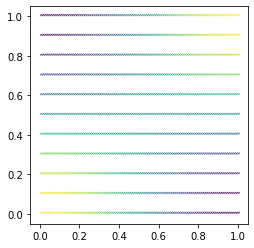

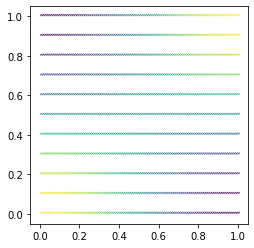

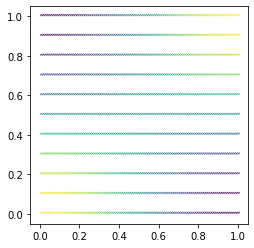

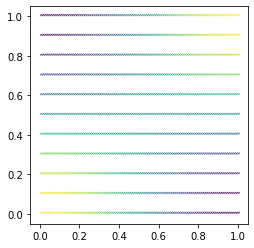

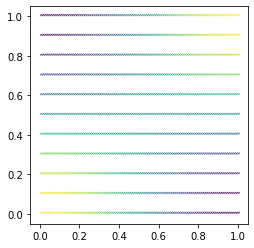

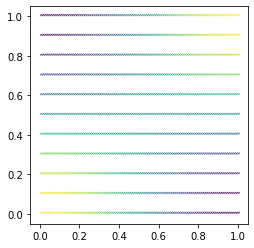

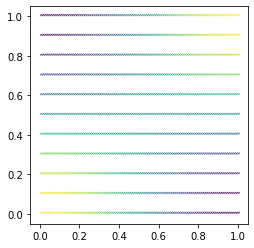

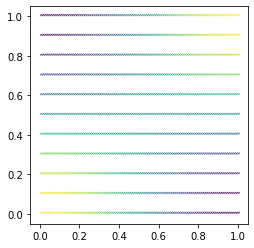

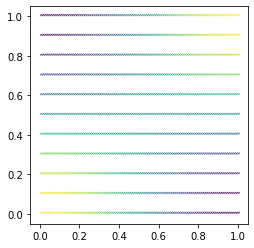

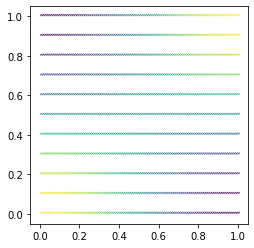

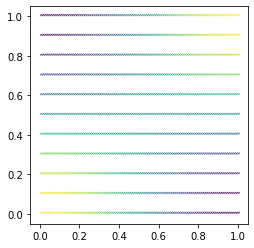

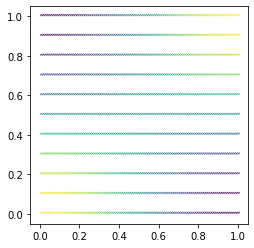

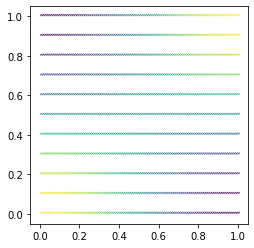

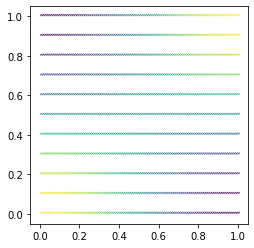

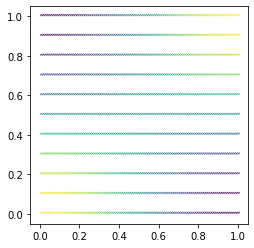

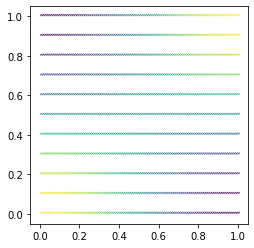

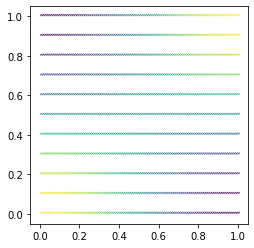

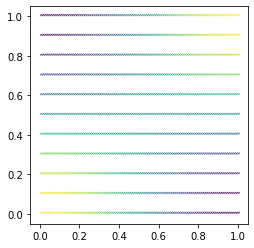

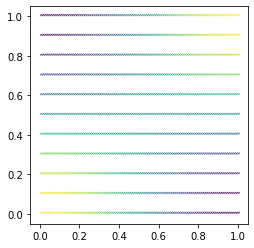

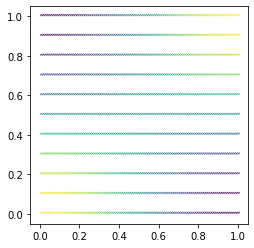

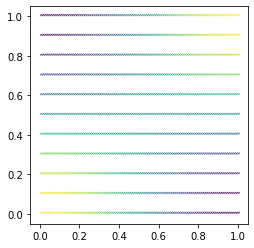

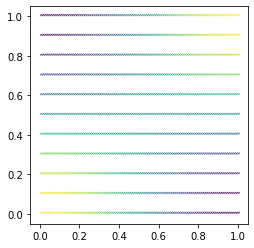

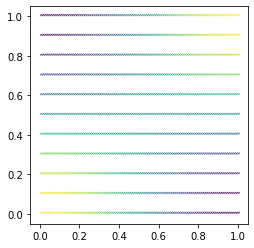

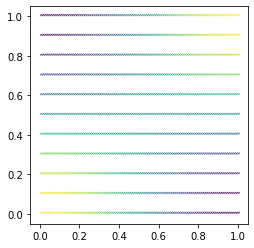

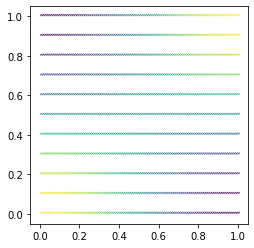

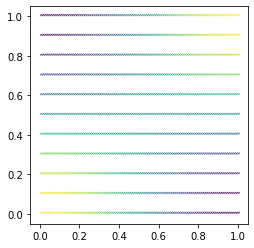

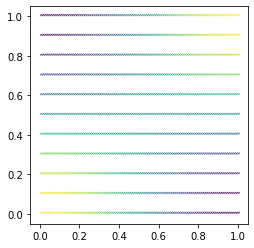

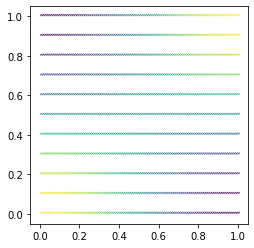

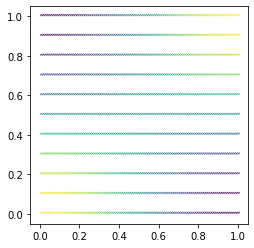

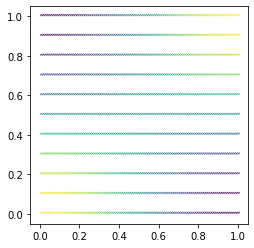

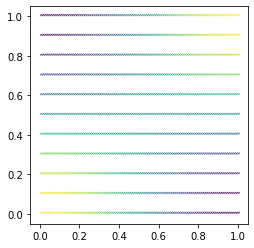

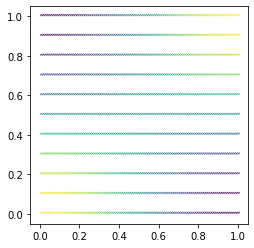

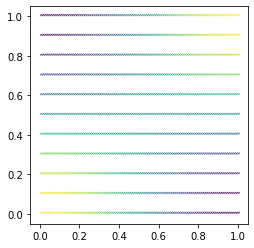

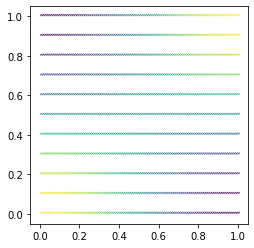

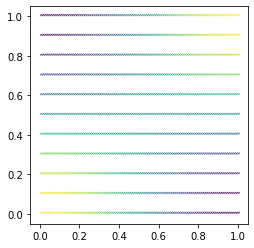

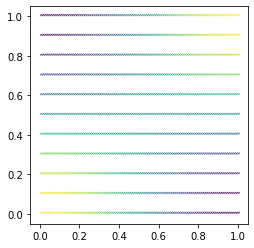

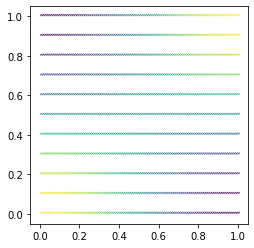

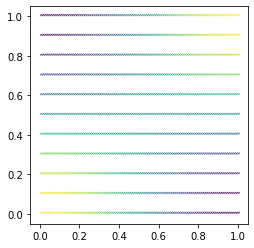

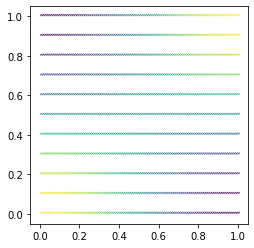

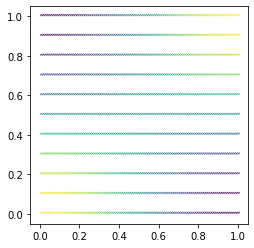

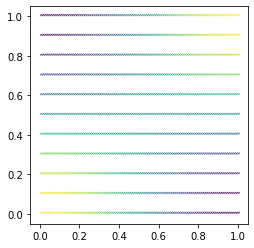

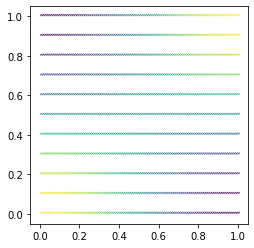

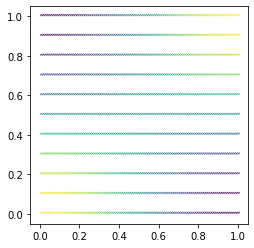

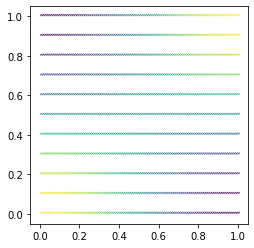

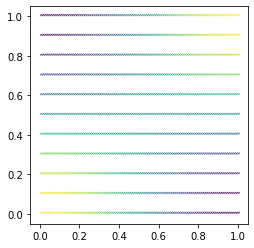

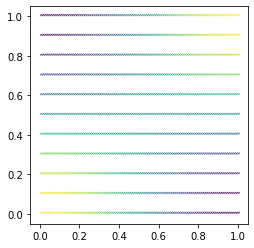

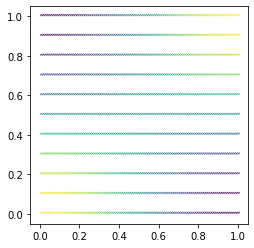

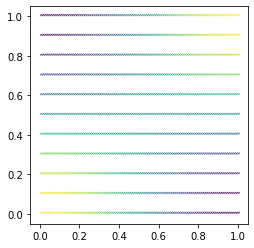

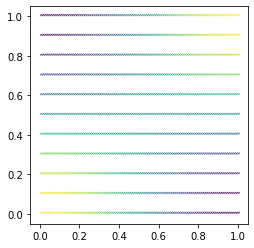

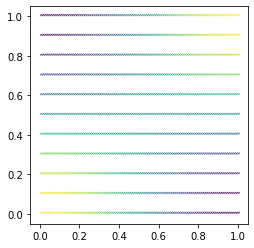

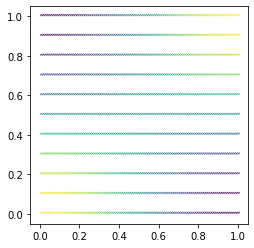

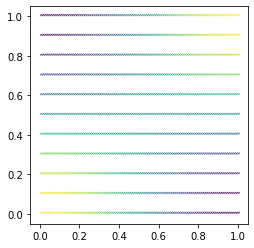

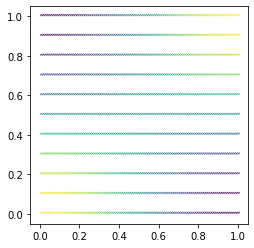

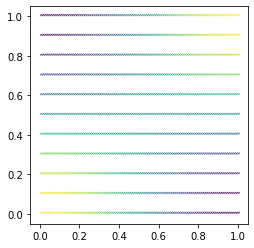

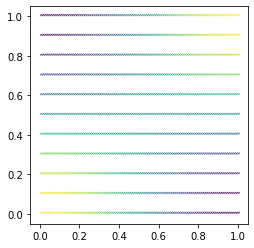

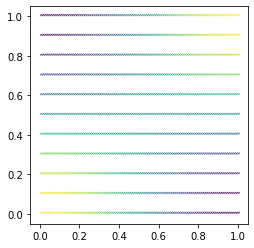

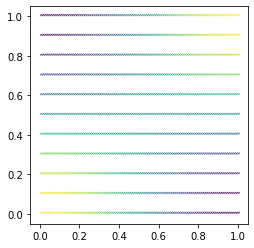

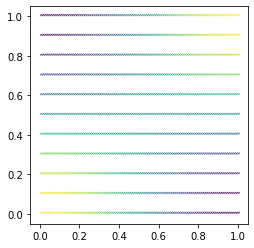

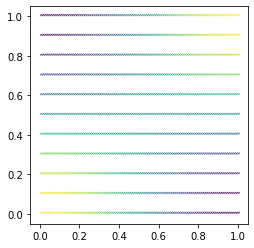

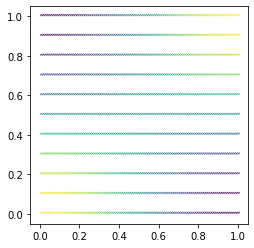

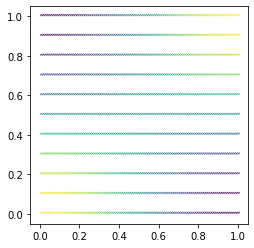

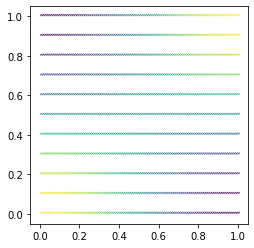

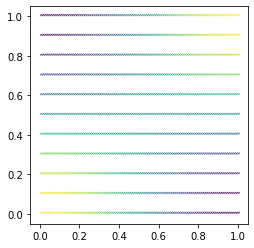

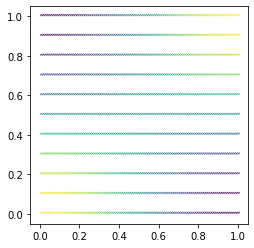

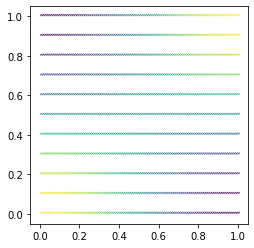

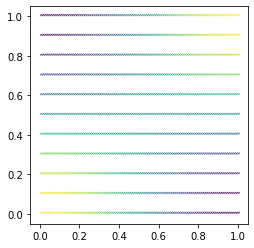

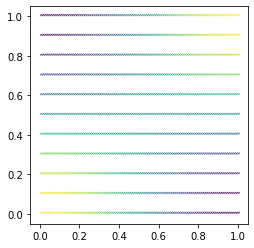

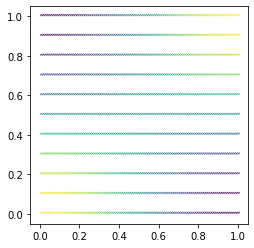

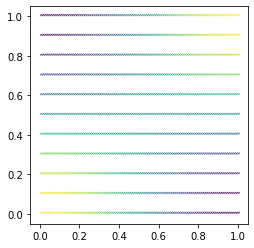

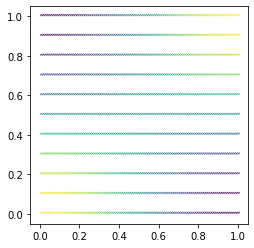

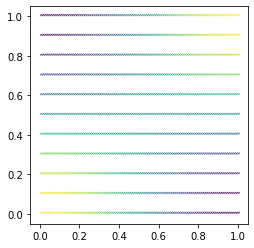

'RD_modelling/chaste_test/General/4'

In [10]:
General_pde_solver(source_term,parameterList,variable_names,diffusionValues,var_init_conds,boundary_conditions,file_root,simulation_tag,simulationType,domainType,[t_initial,t_end,dt],[nx,ny])

## Adding sources

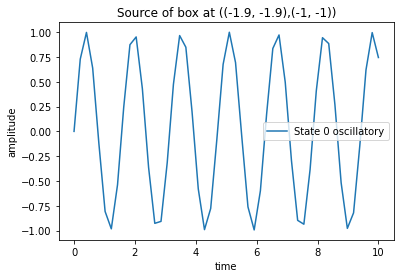

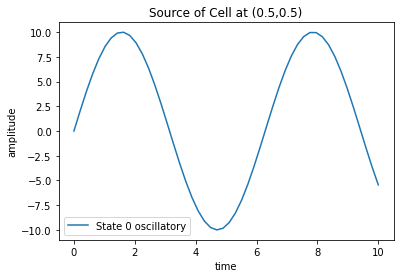

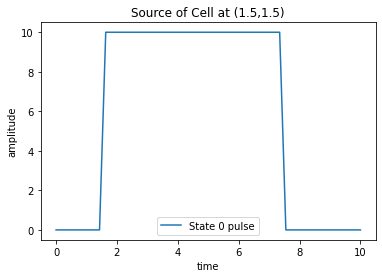

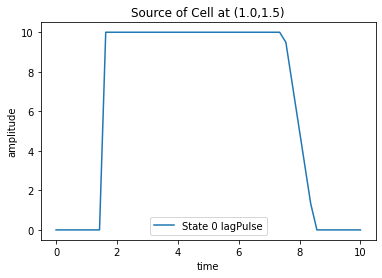

In [11]:

cellSources = [
    {"location":(0.5,0.5), "radius":1e-2, "function":["oscillatory"], "parameters":[{"amplitude":10.0,"frequency":1.0,"phase":0.0}]},
    {"location":(1.5,1.5), "radius":1e-2, "function":["pulse"], "parameters":[{"amplitude":10.0,"duration":(1.5,7.5)}]},
    {"location":(1.0,1.5), "radius":1e-2, "function":["lagPulse"], "parameters":[{"amplitude":10.0,"duration":(1.5,7.5), "lag":1.0}]}
]

boxSources =[
    {"location":[(-1.9,-1.9),(-1.0,-1.9),(-1,-1),(-1.9,-1.0)], "function":["oscillatory"], "parameters":[{"amplitude":1.0,"frequency":4.0,"phase":0.0}]}   
]

T = 10            # final time
num_steps = 50   # number of time steps
dt = T / num_steps # time step size

plotBoxFunctions(boxSources,T,dt)
plotCellFunctions(cellSources,T,dt)

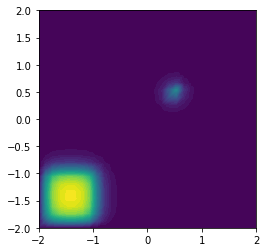

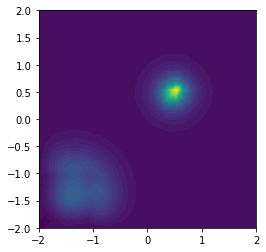

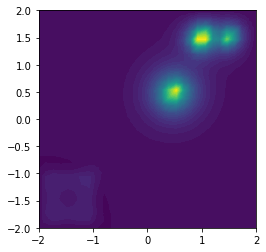

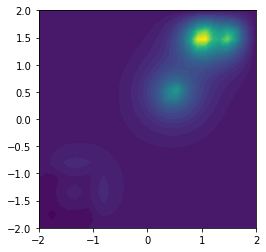

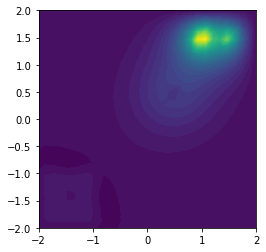

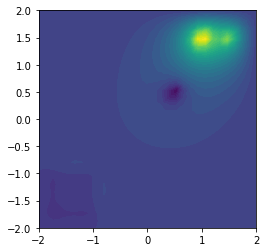

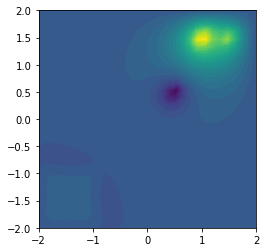

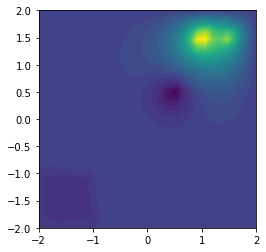

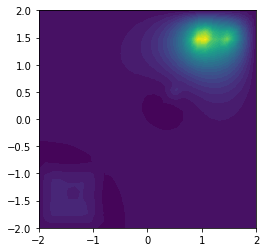

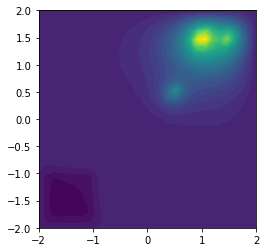

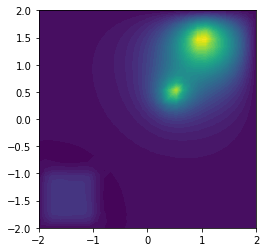

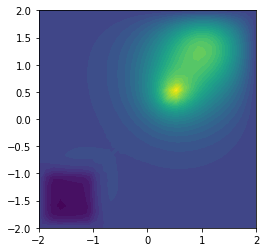

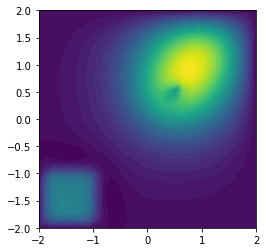

In [12]:

# Create mesh and define function space
nx = ny = 30
mesh = RectangleMesh(Point(-2, -2), Point(2, 2), nx, ny)
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, Constant(0), boundary)

# Define initial value
#u_0 = Expression('exp(-a*pow(x[0], 2) - a*pow(x[1], 2))',
#                 degree=2, a=0.001)
u_0 = Constant(0)

u_n = interpolate(u_0, V)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
#f= Expression('sqrt((x[0] - x0)(x[0] - x0) + (x[1] - y0)(x[1] - y0) ) < 1e-4 ? 0.1 : 0.0', degree = 1)
#f = Expression('pow(x[0]-1,2)+pow(x[1]-1,2)<1e-2 ? -1 : 0',
#                 degree=1)


#f = BoxSourceSet(t=0, boxSources=boxSources,degree=1)#CellSourceSet(t=0, cellSources=cellSources,degree=1)#CellSourceAtX0(t=0, x0=[1,1], degree = 1, eps=1e-2 )
f = GeometricSourceSet(t=0, cellSources=cellSources, boxSources=boxSources,degree=1)
F = u*v*dx + 0.1*dt*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
a, L = lhs(F), rhs(F)


# Create VTK file for saving solution
vtkfile = File('heat_gaussian/solution.pvd')


#plotting stuff
numberRows = 4
numberColumns = 4
#figure, axes = plt.subplots(nrows=4, ncols=4)
numberOfPlots = numberRows*numberColumns
plotSampleRate = ceil(num_steps/numberOfPlots)


xyvals = mesh.coordinates()

# Time-stepping
u = Function(V)
t = 0
plotIndex = 0
plotRowIndex=0
plotColumnIndex=0
for n in range(num_steps):

    # Update current time
    t += dt
    # update user expression with the time
    f.t = t
    
    
    # Compute solution
    solve(a == L, u, bc)

    # Save to file and plot solution
    vtkfile << (u, t)
    
    if(n==plotIndex*plotSampleRate):
        
        
        plotIndex = plotIndex +1
        
        plot(u)
        plt.show()

    # Update previous solution
    u_n.assign(u)

# Hold plot
plt.show()              
                
                

## Diffusion inhibition

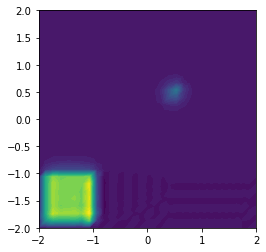

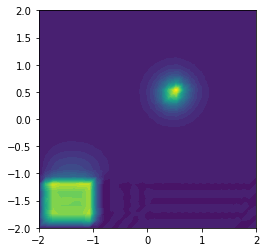

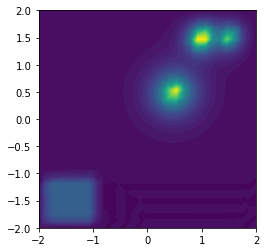

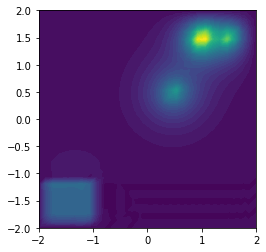

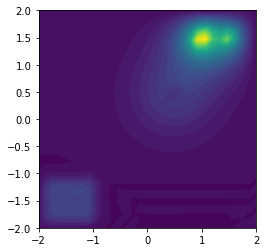

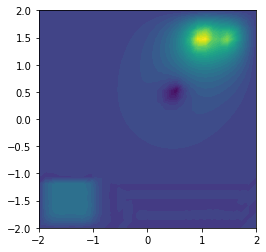

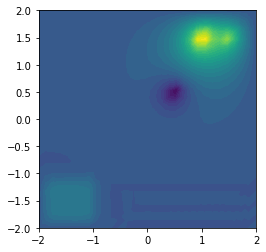

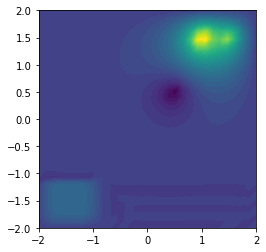

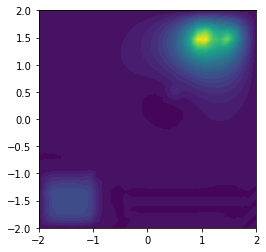

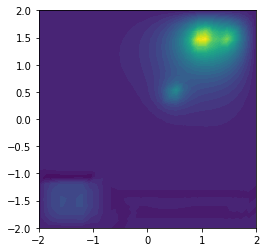

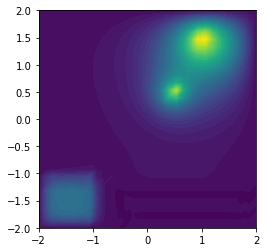

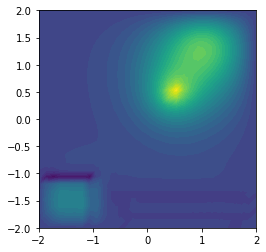

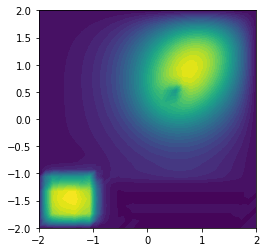

In [13]:
subRegionByLocation=[
    {"yValue":-1,"diffusionFactor":0.01}
    
]


cellSources = [
    {"location":(0.5,0.5), "radius":1e-2, "function":["oscillatory"], "parameters":[{"amplitude":10.0,"frequency":1.0,"phase":0.0}]},
    {"location":(1.5,1.5), "radius":1e-2, "function":["pulse"], "parameters":[{"amplitude":10.0,"duration":(1.5,7.5)}]},
    {"location":(1.0,1.5), "radius":1e-2, "function":["lagPulse"], "parameters":[{"amplitude":10.0,"duration":(1.5,7.5), "lag":1.0}]}
]

boxSources =[
    {"location":[(-1.9,-1.9),(-1.0,-1.9),(-1,-1),(-1.9,-1.0)], "function":["oscillatory"], "parameters":[{"amplitude":1.0,"frequency":4.0,"phase":0.0}]}   
]

T = 10            # final time
num_steps = 50   # number of time steps
dt = T / num_steps # time step size


# Create mesh and define function space
nx = ny = 30
mesh = RectangleMesh(Point(-2, -2), Point(2, 2), nx, ny)
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, Constant(0), boundary)

# Define initial value
#u_0 = Expression('exp(-a*pow(x[0], 2) - a*pow(x[1], 2))',
#                 degree=2, a=0.001)
u_0 = Constant(0)

u_n = interpolate(u_0, V)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = GeometricSourceSet(t=0, cellSources=cellSources, boxSources=boxSources,degree=1)

k = K(subRegionByLocation[0]["yValue"],subRegionByLocation[0]["diffusionFactor"],t=0)


F = u*v*dx + 0.1*k*dt*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
a, L = lhs(F), rhs(F)


# Create VTK file for saving solution
vtkfile = File('heat_gaussian/solution.pvd')


#plotting stuff
numberRows = 4
numberColumns = 4
#figure, axes = plt.subplots(nrows=4, ncols=4)
numberOfPlots = numberRows*numberColumns
plotSampleRate = ceil(num_steps/numberOfPlots)


xyvals = mesh.coordinates()

# Time-stepping
u = Function(V)
t = 0
plotIndex = 0
plotRowIndex=0
plotColumnIndex=0
for n in range(num_steps):

    # Update current time
    t += dt
    # update user expression with the time
    f.t = t
    
    
    # Compute solution
    solve(a == L, u, bc)

    # Save to file and plot solution
    vtkfile << (u, t)
    
    if(n==plotIndex*plotSampleRate):
        
        
        plotIndex = plotIndex +1
        
        plot(u)
        plt.show()

    # Update previous solution
    u_n.assign(u)

# Hold plot
plt.show()              
                
                